# FraudFlow — MLOps Pipeline Showcase

**End-to-end demonstration** of the FraudFlow pipeline using synthetic data.

This notebook runs without Kaggle credentials — it generates an Elliptic-like Bitcoin transaction dataset with graph structure and known fraud signals.

| Stage | Component |
|-------|----------|
| 1 | Synthetic data generation |
| 2 | Graph feature engineering |
| 3 | Temporal train/val/test split |
| 4 | Model training & evaluation |
| 5 | SHAP explainability |
| 6 | Model comparison |
| 7 | Serving demo |

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, roc_auc_score, f1_score,
    average_precision_score
)
import warnings
warnings.filterwarnings('ignore')

from src.features.engineer import build_graph, compute_graph_features
from src.data.split import temporal_split
from src.training.models import create_model, get_feature_columns
from src.training.train import compute_metrics, hybrid_resample

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 120

SEED = 42
rng = np.random.RandomState(SEED)
print('Setup complete')

Setup complete


---
## 1. Synthetic Data Generation

We create 3000 synthetic transactions across 10 timesteps with:
- 20 raw features per transaction
- ~75% licit, ~15% illicit, ~10% unknown labels
- Injected signal: illicit nodes have shifted features 0 & 1
- ~6000 directed edges (random graph)

In [6]:
N_NODES = 3000
N_FEATURES = 20
N_TIMESTEPS = 10

# Generate transactions
tx_ids = np.arange(N_NODES)
timesteps = rng.randint(1, N_TIMESTEPS + 1, size=N_NODES)
features = rng.randn(N_NODES, N_FEATURES)

# Labels
labels = rng.choice([0, 1, -1], size=N_NODES, p=[0.75, 0.15, 0.10])

# Inject learnable signal for illicit transactions
illicit_mask = labels == 1
features[illicit_mask, 0] += 2.0   # Strong shift on feature 0
features[illicit_mask, 1] -= 1.5   # Shift on feature 1
features[illicit_mask, 2] += 0.8   # Mild shift on feature 2

# Build DataFrame
feat_cols = [f'feat_{i}' for i in range(N_FEATURES)]
df = pd.DataFrame(features, columns=feat_cols)
df.insert(0, 'txId', tx_ids)
df.insert(1, 'timestep', timesteps)
df['label'] = labels

# Generate edges
N_EDGES = N_NODES * 2
src_nodes = rng.randint(0, N_NODES, size=N_EDGES)
dst_nodes = rng.randint(0, N_NODES, size=N_EDGES)
edges_df = pd.DataFrame({'txId1': src_nodes, 'txId2': dst_nodes})
edges_df = edges_df[edges_df['txId1'] != edges_df['txId2']].drop_duplicates()

print(f'Transactions: {len(df):,}')
print(f'Edges:        {len(edges_df):,}')
vals, counts = np.unique(labels, return_counts=True)
print(f'Label dist:   {dict(zip(vals.tolist(), counts.tolist()))}')
print(f'Timesteps:    {sorted(int(t) for t in df["timestep"].unique())}')
df.head()

Transactions: 3,000
Edges:        5,995
Label dist:   {-1: 311, 0: 2255, 1: 434}
Timesteps:    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


,txId,timestep,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,label
0,0,8,-0.601135,1.565296,-1.962051,0.264215,1.263672,-1.769547,0.017886,-2.268619,...,1.056135,0.171207,0.203230,0.421212,-0.343488,0.048217,-1.267179,3.591999,0.449464,-1
1,1,5,-0.710988,1.526015,2.032681,-0.554175,-0.632721,1.847178,-1.085098,0.515891,...,0.224814,0.357373,-0.949006,0.047115,-0.022187,-0.600967,-0.612124,-0.794039,0.926946,0
2,2,6,0.085993,-1.019464,0.863605,1.132262,-0.307227,-0.683083,1.356858,1.801545,...,-2.002459,1.209132,-1.496831,-0.866803,-0.449899,0.578296,-2.762406,0.085560,1.722344,-1
3,3,3,-0.645343,0.712930,-0.475531,0.281508,-0.146539,-1.009059,0.495762,0.239656,...,0.364989,-0.714883,0.695293,-1.194513,0.113195,-0.458509,0.426452,-0.789321,0.465640,-1
4,4,1,0.012286,1.342222,-1.756196,-0.942271,-0.573691,0.261433,0.416363,0.567696,...,0.762355,-0.770030,0.395967,0.176452,-1.565080,0.404800,2.631791,2.020962,1.121919,0


### Label Distribution

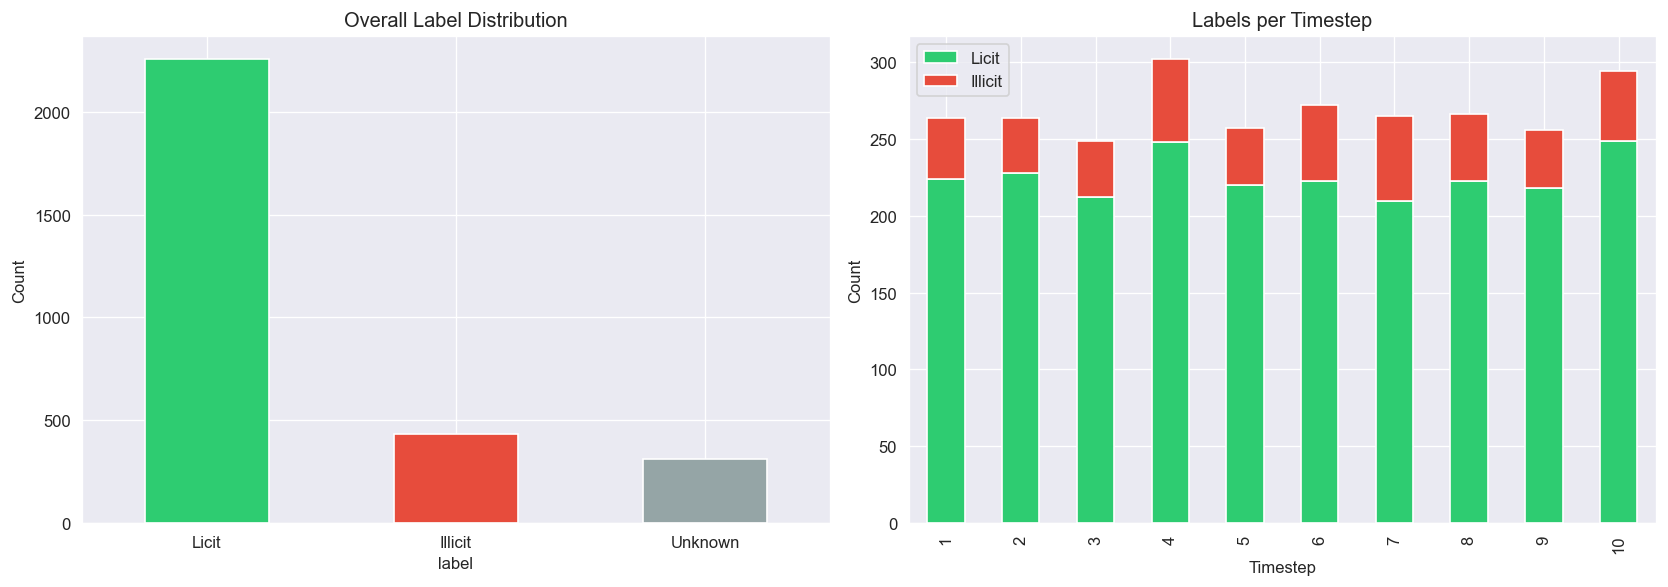

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall label distribution
label_map = {0: 'Licit', 1: 'Illicit', -1: 'Unknown'}
label_counts = df['label'].map(label_map).value_counts()
colors = {'Licit': '#2ecc71', 'Illicit': '#e74c3c', 'Unknown': '#95a5a6'}
label_counts.plot.bar(ax=axes[0], color=[colors[l] for l in label_counts.index])
axes[0].set_title('Overall Label Distribution')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Labels per timestep
known = df[df['label'] != -1]
ts_label = known.groupby(['timestep', 'label']).size().unstack(fill_value=0)
ts_label.columns = ['Licit', 'Illicit']
ts_label.plot.bar(stacked=True, ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Labels per Timestep')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Timestep')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 2. Graph Feature Engineering

Build a directed graph from the edgelist and compute topology features:
- **Degree** (total, in, out)
- **PageRank** — global importance in the transaction network
- **Clustering coefficient** — local connectivity structure

In [8]:
G = build_graph(edges_df)
print(f'Graph: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges')

# Compute graph features
enriched = compute_graph_features(df.copy(), G, ['degree', 'pagerank', 'clustering_coefficient'])
print(f'Enriched features: {enriched.shape[1]} columns')
enriched[['txId', 'graph_degree', 'graph_in_degree', 'graph_out_degree', 'graph_pagerank', 'graph_clustering_coeff']].describe().round(4)

Graph: 2,947 nodes, 5,995 edges
Enriched features: 28 columns


,txId,graph_degree,graph_in_degree,graph_out_degree,graph_pagerank,graph_clustering_coeff
count,3000.0000,3000.0000,3000.0000,3000.0000,3000.0000,3000.0000
mean,1499.5000,3.9967,1.9983,1.9983,0.0003,0.0010
std,866.1697,1.9993,1.4261,1.4082,0.0002,0.0208
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,749.7500,3.0000,1.0000,1.0000,0.0002,0.0000
50%,1499.5000,4.0000,2.0000,2.0000,0.0003,0.0000
75%,2249.2500,5.0000,3.0000,3.0000,0.0005,0.0000
max,2999.0000,12.0000,8.0000,7.0000,0.0023,1.0000


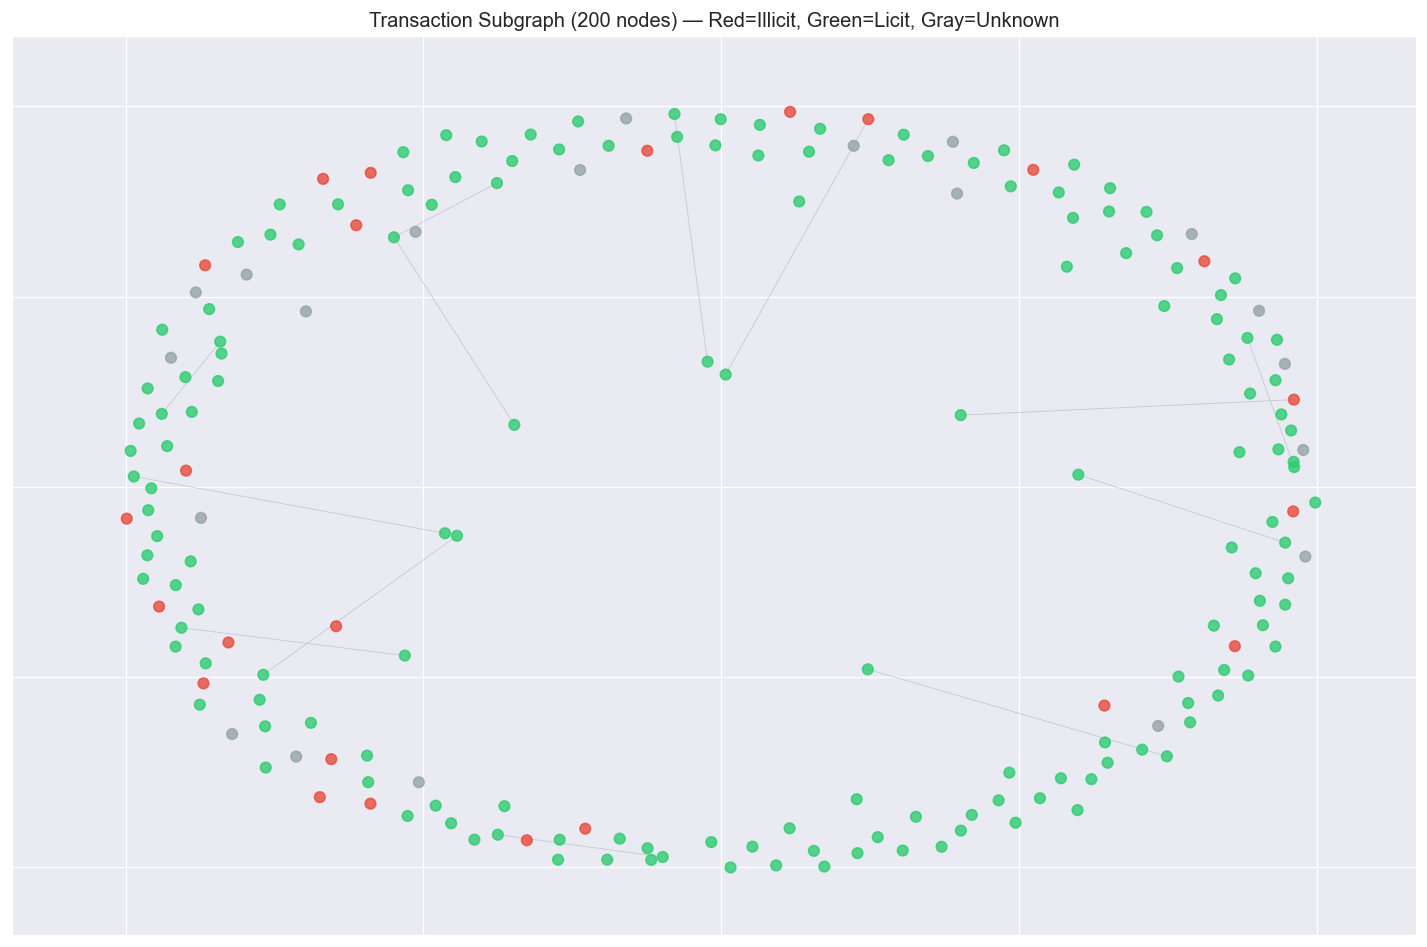

In [9]:
# Visualize a subgraph colored by label
sample_nodes = list(range(200))  # First 200 nodes
G_sub = G.subgraph([n for n in sample_nodes if n in G])

node_colors = []
for n in G_sub.nodes():
    lbl = df.loc[df['txId'] == n, 'label'].values
    if len(lbl) > 0 and lbl[0] == 1:
        node_colors.append('#e74c3c')  # illicit = red
    elif len(lbl) > 0 and lbl[0] == 0:
        node_colors.append('#2ecc71')  # licit = green
    else:
        node_colors.append('#95a5a6')  # unknown = gray

fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G_sub, seed=SEED, k=0.3)
nx.draw_networkx(
    G_sub, pos, ax=ax,
    node_color=node_colors, node_size=40, with_labels=False,
    edge_color='#bdc3c7', alpha=0.8, width=0.5, arrows=False,
)
ax.set_title('Transaction Subgraph (200 nodes) — Red=Illicit, Green=Licit, Gray=Unknown')
plt.tight_layout()
plt.show()

---
## 3. Temporal Train / Val / Test Split

Split by timestep to prevent data leakage:
- **Train**: timesteps 1–7
- **Val**: timesteps 8–9
- **Test**: timestep 10

In [10]:
import tempfile
from pathlib import Path

tmp = Path(tempfile.mkdtemp())
processed_dir = tmp / 'processed'
splits_dir = tmp / 'splits'
processed_dir.mkdir()

# Save enriched features
enriched.to_parquet(processed_dir / 'features.parquet', index=False)

# Split
stats = temporal_split(
    features_path=processed_dir / 'features.parquet',
    splits_dir=splits_dir,
    train_ts=(1, 7),
    val_ts=(8, 9),
    test_ts=(10, 10),
    seed=SEED,
)

train_df = pd.read_parquet(splits_dir / 'train.parquet')
val_df = pd.read_parquet(splits_dir / 'val.parquet')
test_df = pd.read_parquet(splits_dir / 'test.parquet')

print(f"Train: {len(train_df):,} (illicit: {(train_df['label']==1).sum():,})")
print(f"Val:   {len(val_df):,} (illicit: {(val_df['label']==1).sum():,})")
print(f"Test:  {len(test_df):,} (illicit: {(test_df['label']==1).sum():,})")

Train: 1,873 (illicit: 308)
Val:   522 (illicit: 81)
Test:  294 (illicit: 45)


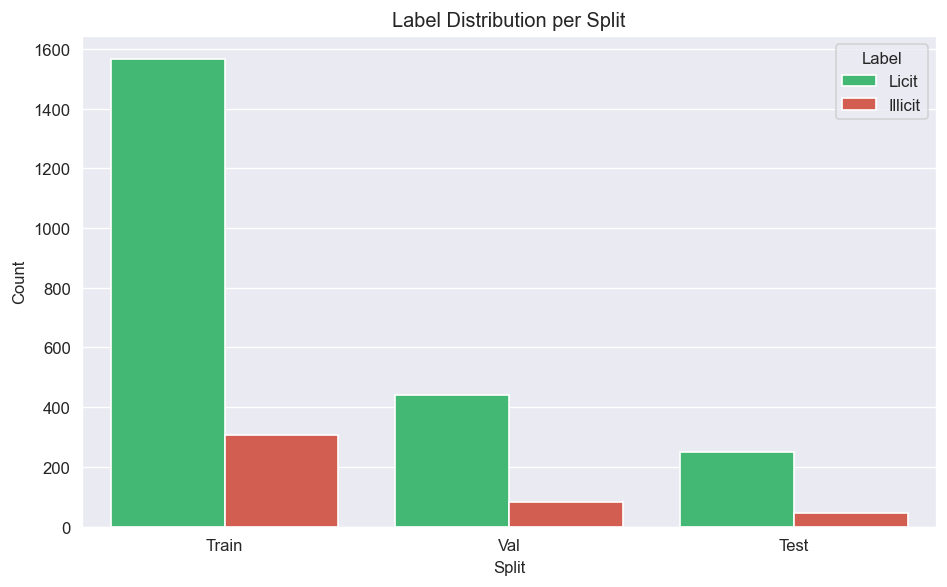

In [11]:
# Split composition visualization
fig, ax = plt.subplots(figsize=(8, 5))
split_data = pd.DataFrame({
    'Split': ['Train', 'Train', 'Val', 'Val', 'Test', 'Test'],
    'Label': ['Licit', 'Illicit'] * 3,
    'Count': [
        (train_df['label']==0).sum(), (train_df['label']==1).sum(),
        (val_df['label']==0).sum(), (val_df['label']==1).sum(),
        (test_df['label']==0).sum(), (test_df['label']==1).sum(),
    ]
})
sns.barplot(data=split_data, x='Split', y='Count', hue='Label',
            palette={'Licit': '#2ecc71', 'Illicit': '#e74c3c'}, ax=ax)
ax.set_title('Label Distribution per Split')
plt.tight_layout()
plt.show()

---
## 4. Model Training

Train an XGBoost classifier with hybrid resampling and auto `scale_pos_weight`.

In [12]:
feature_cols = get_feature_columns(train_df)
print(f'Features: {len(feature_cols)}')

X_train = train_df[feature_cols].fillna(0).values
y_train = train_df['label'].values
X_val = val_df[feature_cols].fillna(0).values
y_val = val_df['label'].values
X_test = test_df[feature_cols].fillna(0).values
y_test = test_df['label'].values

# Hybrid resampling
X_train_r, y_train_r = hybrid_resample(
    X_train, y_train,
    max_majority=1500, target_minority_ratio=0.3, seed=SEED
)
print(f'After resampling: {len(X_train_r):,} samples '
      f'({(y_train_r==1).sum():,} illicit, {(y_train_r==0).sum():,} licit)')

# Train
n_pos = int((y_train_r == 1).sum())
n_neg = int((y_train_r == 0).sum())
model = create_model('xgboost', {
    'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1,
    'subsample': 0.8, 'colsample_bytree': 0.8,
    'eval_metric': 'aucpr', 'random_state': SEED,
}, n_pos, n_neg)

model.fit(X_train_r, y_train_r, eval_set=[(X_val, y_val)], verbose=False)

# Evaluate
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]
val_metrics = compute_metrics(y_val, y_val_pred, y_val_prob)

print('\n─── Validation Metrics ───')
for k, v in val_metrics.items():
    print(f'  {k:25s} {v:.4f}')

Features: 25
After resampling: 2,142 samples (642 illicit, 1,500 licit)

─── Validation Metrics ───
  accuracy                  0.9291
  f1_illicit                0.7702
  f1_macro                  0.8641
  precision_illicit         0.7750
  recall_illicit            0.7654
  auc_roc                   0.9584
  auc_pr                    0.8839


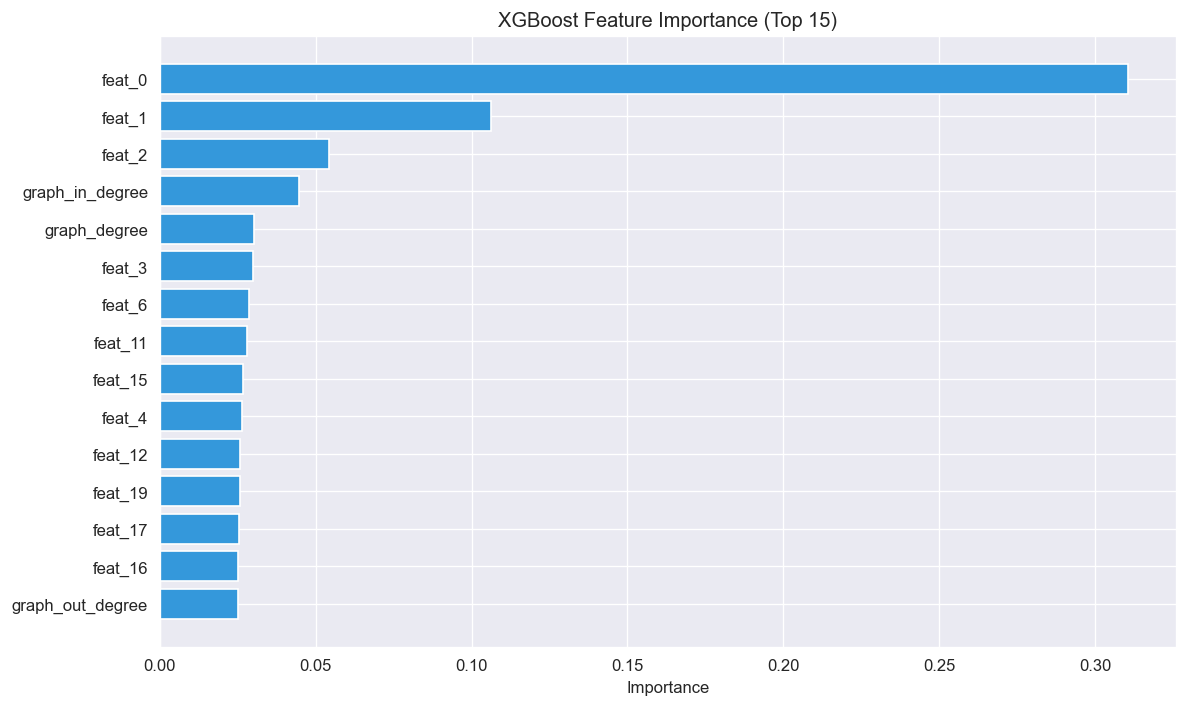

In [13]:
# Feature importance
if hasattr(model, 'feature_importances_'):
    imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(imp['feature'], imp['importance'], color='#3498db')
    ax.set_title('XGBoost Feature Importance (Top 15)')
    ax.set_xlabel('Importance')
    plt.tight_layout()
    plt.show()

---
## 5. Evaluation — Test Set

Evaluate the trained model on the held-out test set (timestep 10).

In [14]:
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]
test_metrics = compute_metrics(y_test, y_test_pred, y_test_prob)

print('─── Test Metrics ───')
for k, v in test_metrics.items():
    print(f'  {k:25s} {v:.4f}')

─── Test Metrics ───
  accuracy                  0.9252
  f1_illicit                0.7381
  f1_macro                  0.8472
  precision_illicit         0.7949
  recall_illicit            0.6889
  auc_roc                   0.9566
  auc_pr                    0.7859


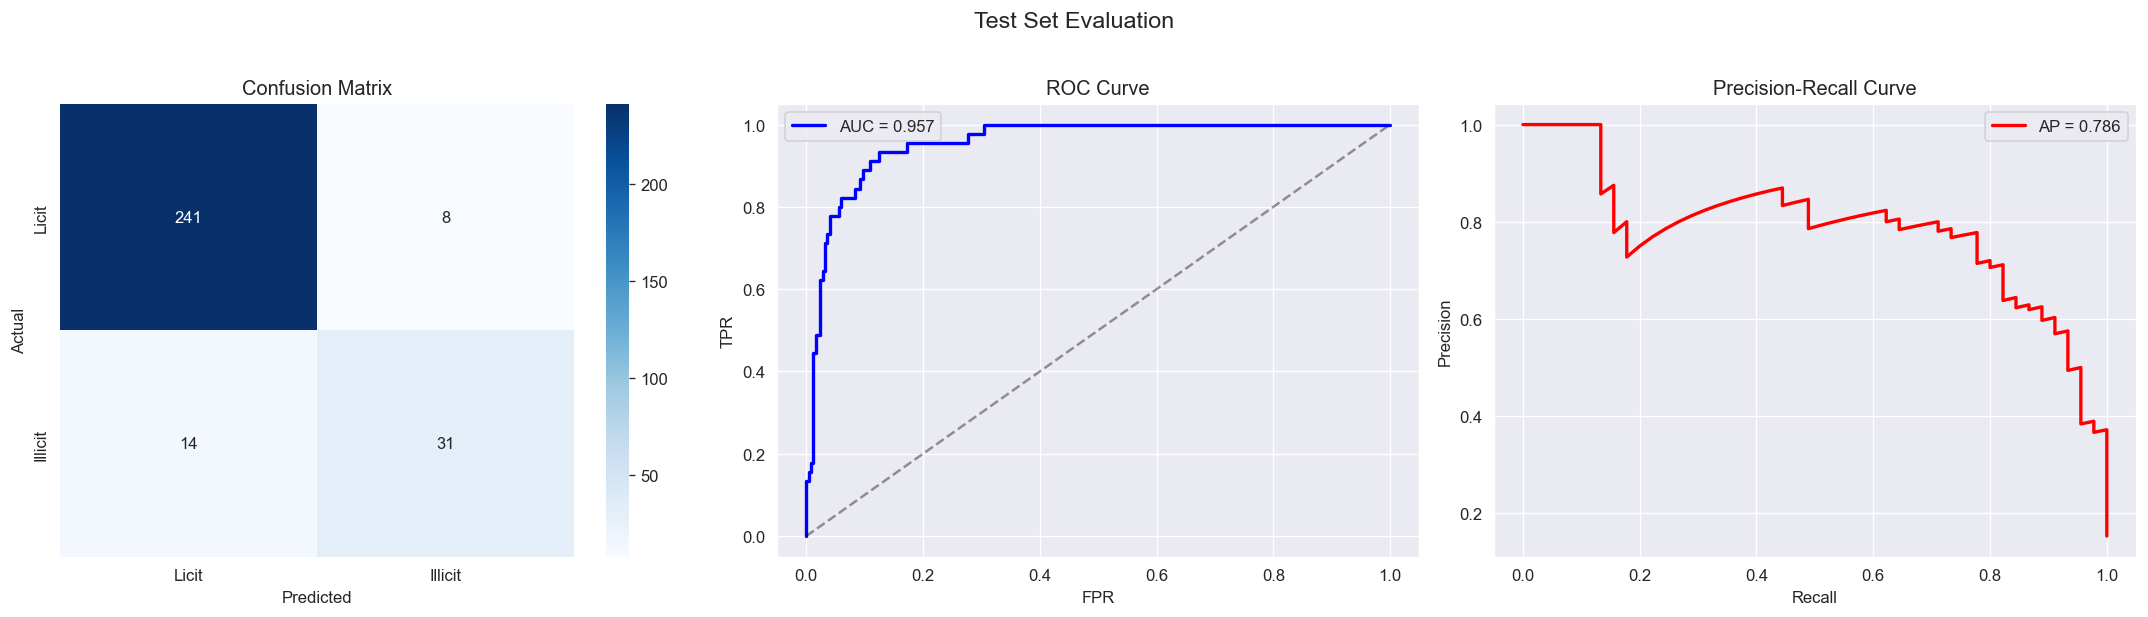

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Licit', 'Illicit'], yticklabels=['Licit', 'Illicit'])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {test_metrics["auc_roc"]:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.4)
axes[1].set_title('ROC Curve')
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].legend()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_test_prob)
axes[2].plot(rec, prec, 'r-', linewidth=2, label=f'AP = {test_metrics["auc_pr"]:.3f}')
axes[2].set_title('Precision-Recall Curve')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].legend()

plt.suptitle('Test Set Evaluation', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [17]:
print(classification_report(y_test, y_test_pred, target_names=['Licit', 'Illicit'], zero_division=0))

              precision    recall  f1-score   support

       Licit       0.95      0.97      0.96       249
     Illicit       0.79      0.69      0.74        45

    accuracy                           0.93       294
   macro avg       0.87      0.83      0.85       294
weighted avg       0.92      0.93      0.92       294



---
## 6. SHAP Explainability

Using TreeExplainer to understand which features drive fraud predictions.

In [18]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# Handle 3D output from binary classifier
if isinstance(shap_values.values, np.ndarray) and shap_values.values.ndim == 3:
    shap_values = shap.Explanation(
        values=shap_values.values[:, :, 1],
        base_values=shap_values.base_values[:, 1] if shap_values.base_values.ndim > 1 else shap_values.base_values,
        data=shap_values.data,
        feature_names=feature_cols,
    )
else:
    shap_values.feature_names = feature_cols

print(f'SHAP values computed for {len(shap_values.values)} samples')

SHAP values computed for 294 samples


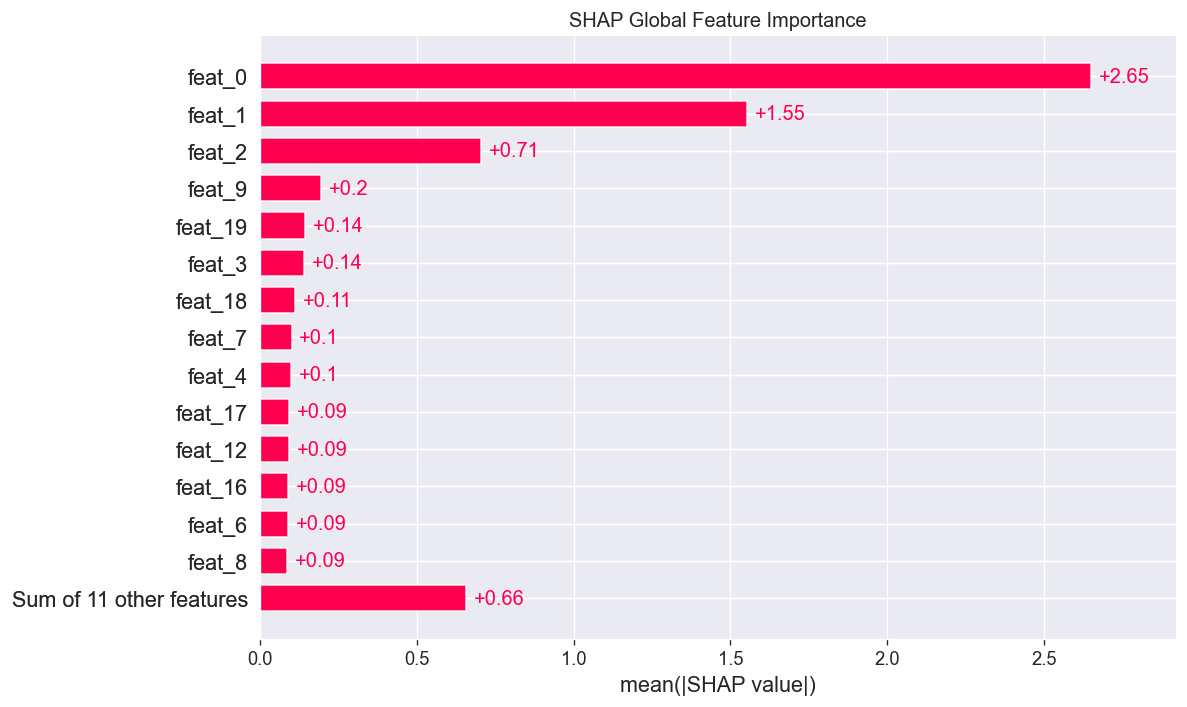

In [19]:
# Global feature importance (bar)
fig, ax = plt.subplots(figsize=(10, 6))
shap.plots.bar(shap_values, max_display=15, show=False, ax=ax)
ax.set_title('SHAP Global Feature Importance')
plt.tight_layout()
plt.show()

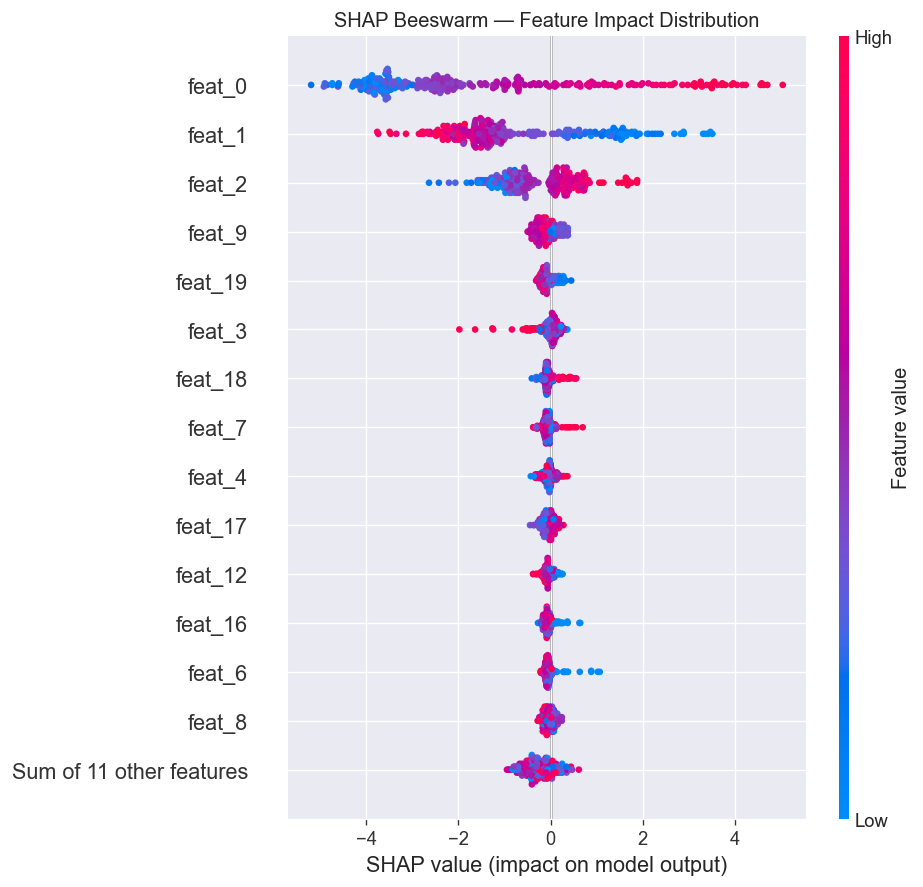

In [20]:
# Beeswarm
fig = plt.figure(figsize=(10, 7))
shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.title('SHAP Beeswarm — Feature Impact Distribution')
plt.tight_layout()
plt.show()

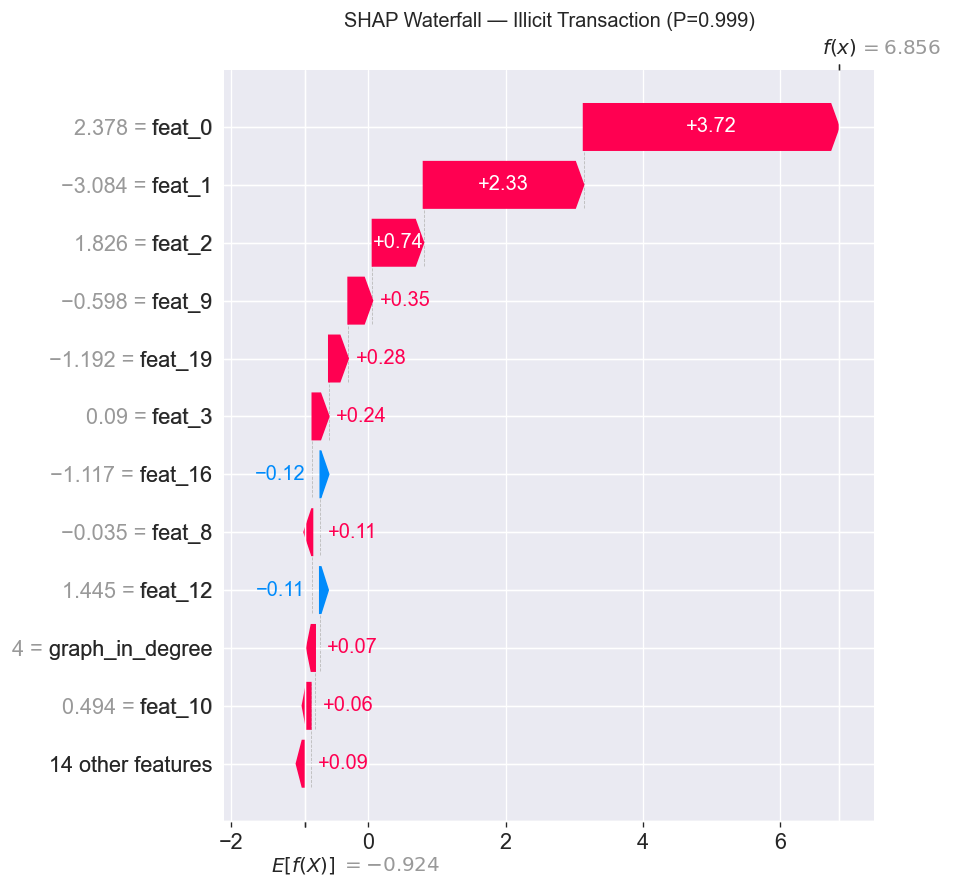

In [21]:
# Waterfall for a high-confidence illicit prediction
illicit_idx = np.where(y_test == 1)[0]
top_illicit = illicit_idx[np.argmax(y_test_prob[illicit_idx])]

fig = plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[top_illicit], max_display=12, show=False)
plt.title(f'SHAP Waterfall — Illicit Transaction (P={y_test_prob[top_illicit]:.3f})')
plt.tight_layout()
plt.show()

---
## 7. Model Comparison

Compare XGBoost, Random Forest, and Logistic Regression on the same data.

In [22]:
models_to_compare = {
    'XGBoost': ('xgboost', {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}),
    'Random Forest': ('random_forest', {'n_estimators': 100, 'max_depth': 10}),
    'Logistic Reg': ('logistic_regression', {'max_iter': 1000, 'C': 1.0}),
}

comparison_results = []

for name, (model_type, params) in models_to_compare.items():
    m = create_model(model_type, params, n_pos, n_neg)
    
    if model_type == 'xgboost':
        m.fit(X_train_r, y_train_r, eval_set=[(X_val, y_val)], verbose=False)
    else:
        m.fit(X_train_r, y_train_r)
    
    yp = m.predict(X_test)
    yprob = m.predict_proba(X_test)[:, 1] if hasattr(m, 'predict_proba') else yp.astype(float)
    
    metrics = compute_metrics(y_test, yp, yprob)
    metrics['model'] = name
    comparison_results.append(metrics)
    print(f'{name:18s}  F1={metrics["f1_illicit"]:.3f}  AUC-ROC={metrics["auc_roc"]:.3f}  AUC-PR={metrics["auc_pr"]:.3f}')

comp_df = pd.DataFrame(comparison_results)

XGBoost             F1=0.744  AUC-ROC=0.955  AUC-PR=0.790
Random Forest       F1=0.773  AUC-ROC=0.961  AUC-PR=0.784
Logistic Reg        F1=0.734  AUC-ROC=0.963  AUC-PR=0.836


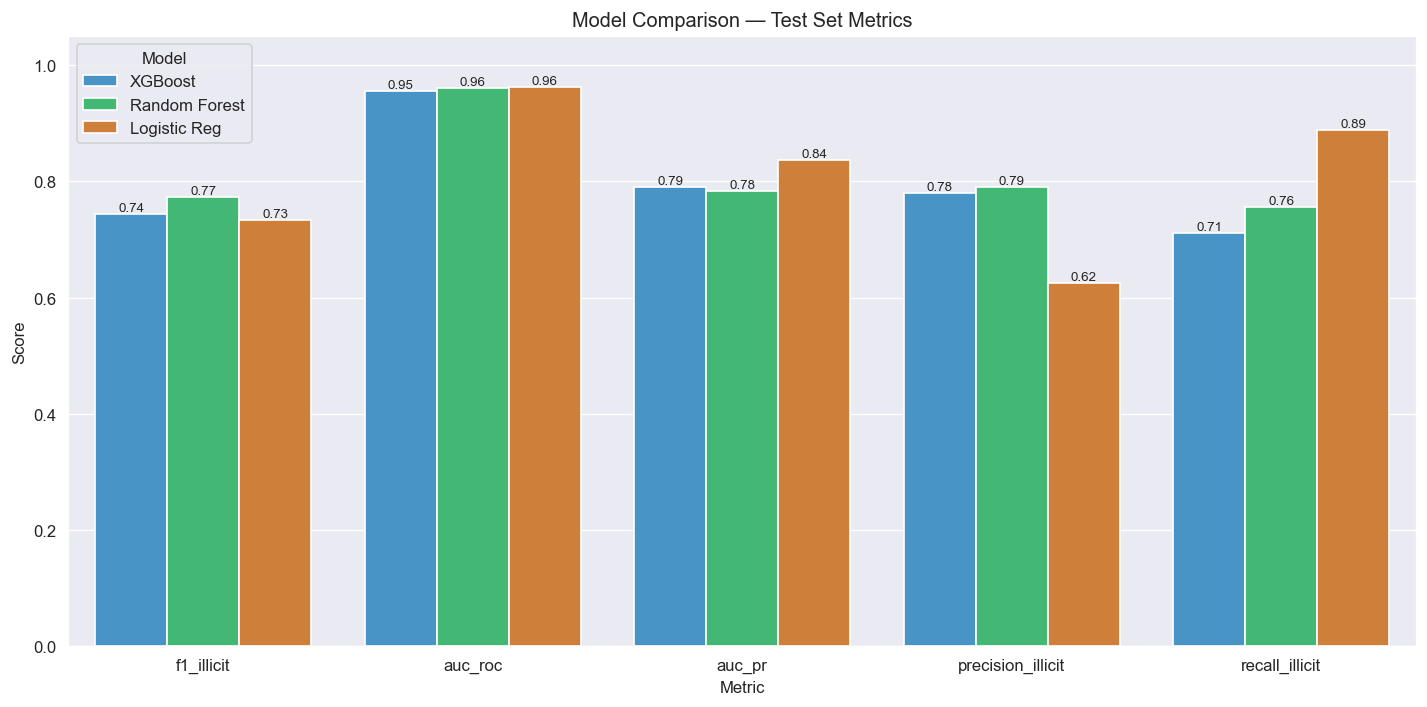

In [23]:
# Grouped bar chart comparison
metric_cols = ['f1_illicit', 'auc_roc', 'auc_pr', 'precision_illicit', 'recall_illicit']
plot_df = comp_df.melt(id_vars='model', value_vars=metric_cols, var_name='Metric', value_name='Score')

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=plot_df, x='Metric', y='Score', hue='model', ax=ax,
            palette=['#3498db', '#2ecc71', '#e67e22'])
ax.set_title('Model Comparison — Test Set Metrics')
ax.set_ylim(0, 1.05)
ax.legend(title='Model')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8)
plt.tight_layout()
plt.show()

---
## 8. FastAPI Serving Demo

FraudFlow includes a production-ready FastAPI endpoint with Prometheus metrics.

```bash
# Launch serving
make serve

# Or via CLI
fraudflow serve --port 8000
```

In [24]:
# Example: how to call the serving endpoint
# (Not executed here — requires running server)

EXAMPLE_CODE = '''
import httpx

# Health check
resp = httpx.get("http://localhost:8000/health")
print(resp.json())
# {"status": "healthy", "model_loaded": true, "model_type": "XGBClassifier", "uptime_sec": 12.3}

# Single prediction
resp = httpx.post("http://localhost:8000/predict", json={
    "features": [sample_features.tolist()]
})
result = resp.json()
print(f"Prediction: {result['predictions'][0]}")
print(f"P(illicit): {result['probabilities'][0]:.3f}")
print(f"Inference:  {result['inference_time_ms']:.1f}ms")

# Prometheus metrics
resp = httpx.get("http://localhost:8000/metrics")
print(resp.text[:500])  # Prometheus text format
'''

print('API endpoints:')
print('  GET  /health     — Service health + model status')
print('  POST /predict    — Batch fraud predictions')
print('  GET  /model/info — Model metadata')
print('  GET  /metrics    — Prometheus scrape endpoint')
print()
print('Example client code:')
print(EXAMPLE_CODE)

API endpoints:
  GET  /health     — Service health + model status
  POST /predict    — Batch fraud predictions
  GET  /model/info — Model metadata
  GET  /metrics    — Prometheus scrape endpoint

Example client code:

import httpx

# Health check
resp = httpx.get("http://localhost:8000/health")
print(resp.json())
# {"status": "healthy", "model_loaded": true, "model_type": "XGBClassifier", "uptime_sec": 12.3}

# Single prediction
resp = httpx.post("http://localhost:8000/predict", json={
    "features": [sample_features.tolist()]
})
result = resp.json()
print(f"Prediction: {result['predictions'][0]}")
print(f"P(illicit): {result['probabilities'][0]:.3f}")
print(f"Inference:  {result['inference_time_ms']:.1f}ms")

# Prometheus metrics
resp = httpx.get("http://localhost:8000/metrics")
print(resp.text[:500])  # Prometheus text format



---
## Summary

| Component | Status | Details |
|-----------|--------|---------|
| **Data Pipeline** | DVC 5-stage | download → featurize → split → train → evaluate |
| **Graph Features** | 6 columns added | degree (in/out), PageRank, clustering coefficient |
| **Temporal Split** | No leakage | Train ≤ ts7, Val ts8-9, Test ts10 |
| **Best Model** | XGBoost | See comparison chart above |
| **Explainability** | SHAP | Global importance + per-transaction waterfall |
| **Experiment Tracking** | MLflow | `make mlflow-ui` to view |
| **HP Tuning** | Optuna | `make tune` for automated search |
| **Drift Monitoring** | Evidently | `make drift` for HTML reports |
| **Serving** | FastAPI + Prometheus | `make serve` → localhost:8000 |
| **CI/CD** | GitHub Actions | Lint → Test → Docker build |
| **Container** | Docker multi-stage | `make docker` to build |